In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=2

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
from sklearn.linear_model import Ridge

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                        ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = Ridge()
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
pickle.dump(validpreds, open('l3_3000_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1571
0
(201158, 1, 32) (201158, 7, 72) (201158, 1) (201158, 1)
(201158, 536) (201158,) (201158,)
(49582, 1, 32) (49582, 7, 72) (49582, 1) (49582, 1)
(49582, 536) (49582,) (49582,)
(5803, 1, 32) (5803, 7, 72) (5803, 1) (5803, 1)
(5803, 536) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


0.24294068 0.24292915
[0.24292915]
-1 mean score 0.24292915
0.214429885149


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927419  0.001691  0.230775    7  2017-04-16
472     2.507290  2.539439 -0.032148  0.235430    1  2017-04-17
473     2.661330  2.668312 -0.006982  0.250593    2  2017-04-18
474     2.754815  2.740935  0.013880  0.206354    3  2017-04-19
475     2.713762  2.712192  0.001570  0.233773    4  2017-04-20
476     2.999000  2.981873  0.017127  0.157290    5  2017-04-21
477     3.075529  3.076098 -0.000568  0.186793    6  2017-04-22

0.214429885149


pred         y     error    error2  day        date
dayidx                                                         
471     2.927419  2.929110  0.001691  0.230775    7  2017-04-16
472     2.539439  2.507290 -0.032148  0.235430    1  2017-04-17
473     2.668312  2.661330 -0.006982  0.250593    2  2017-04-18
474     2.740935  2.754815  0.013880  0.206354    3  2017-04-19
475     2.712192  2.713762  0.001570  0.233773    4  2017-04-20
476     2.981873  2.999000  0.017127  0.157290    5  2017-04-21
477     3.076098  3.075529 -0.000568  0.186793    6  2017-04-22

(829, 1072)


2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200932, 2) (49525, 2)
train/valid # (200932, 2) (49525, 2)
rand split across time
train has 200932 records out of 389630 records
valid has 49525 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1569
0
(200932, 1, 32) (200932, 7, 72) (200932, 1) (200932, 1)
(200932, 536) (200932,) (200932,)
(49525, 1, 32) (49525, 7, 72) (49525, 1) (49525, 1)
(49525, 536) (49525,) (49525,)
(6632, 1, 32) (6632, 7, 72) (6632, 1) (6632, 1)
(6632, 536) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.69478579676e-11 / 5.96046447754e-08
  RuntimeWarning)


0.25140533 0.25445497
[0.25445497]
-1 mean score 0.25445497
0.2201243788


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926525  0.002585  0.239228    7  2017-04-16
472     2.507290  2.541667 -0.034377  0.238361    1  2017-04-17
473     2.661330  2.661319  0.000011  0.259720    2  2017-04-18
474     2.754815  2.738951  0.015864  0.215087    3  2017-04-19
475     2.713762  2.719802 -0.006041  0.240211    4  2017-04-20
476     2.999000  3.000112 -0.001112  0.160584    5  2017-04-21
477     3.075529  3.068353  0.007177  0.187680    6  2017-04-22

0.2201243788


pred         y     error    error2  day        date
dayidx                                                         
471     2.926525  2.929110  0.002585  0.239228    7  2017-04-16
472     2.541667  2.507290 -0.034377  0.238361    1  2017-04-17
473     2.661319  2.661330  0.000011  0.259720    2  2017-04-18
474     2.738951  2.754815  0.015864  0.215087    3  2017-04-19
475     2.719802  2.713762 -0.006041  0.240211    4  2017-04-20
476     3.000111  2.999000 -0.001112  0.160584    5  2017-04-21
477     3.068353  3.075529  0.007177  0.187681    6  2017-04-22

(829, 1072)


3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200747, 2) (49483, 2)
train/valid # (200747, 2) (49483, 2)
rand split across time
train has 200747 records out of 389630 records
valid has 49483 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1568
0
(200747, 1, 32) (200747, 7, 72) (200747, 1) (200747, 1)
(200747, 536) (200747,) (200747,)
(49483, 1, 32) (49483, 7, 72) (49483, 1) (49483, 1)
(49483, 536) (49483,) (49483,)
(7461, 1, 32) (7461, 7, 72) (7461, 1) (7461, 1)
(7461, 536) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.61942490667e-11 / 5.96046447754e-08
  RuntimeWarning)


0.25346377 0.25681785
[0.25681785]
-1 mean score 0.25681785
0.224052906036


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904492  0.024618  0.239002    7  2017-04-16
472     2.507290  2.531014 -0.023724  0.239394    1  2017-04-17
473     2.661330  2.653668  0.007662  0.266229    2  2017-04-18
474     2.754815  2.749994  0.004821  0.225936    3  2017-04-19
475     2.713762  2.709110  0.004651  0.247275    4  2017-04-20
476     2.999000  2.995399  0.003601  0.160407    5  2017-04-21
477     3.075529  3.068058  0.007471  0.190127    6  2017-04-22

0.224052920938


pred         y     error    error2  day        date
dayidx                                                         
471     2.904492  2.929110  0.024618  0.239002    7  2017-04-16
472     2.531014  2.507290 -0.023724  0.239394    1  2017-04-17
473     2.653668  2.661330  0.007662  0.266229    2  2017-04-18
474     2.749993  2.754815  0.004821  0.225936    3  2017-04-19
475     2.709110  2.713762  0.004651  0.247275    4  2017-04-20
476     2.995399  2.999000  0.003601  0.160407    5  2017-04-21
477     3.068058  3.075529  0.007471  0.190127    6  2017-04-22

(829, 1072)


4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200584, 2) (49444, 2)
train/valid # (200584, 2) (49444, 2)
rand split across time
train has 200584 records out of 389630 records
valid has 49444 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1567
0
(200584, 1, 32) (200584, 7, 72) (200584, 1) (200584, 1)
(200584, 536) (200584,) (200584,)
(49444, 1, 32) (49444, 7, 72) (49444, 1) (49444, 1)
(49444, 536) (49444,) (49444,)
(8290, 1, 32) (8290, 7, 72) (8290, 1) (8290, 1)
(8290, 536) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.28126326593e-12 / 5.96046447754e-08
  RuntimeWarning)


0.25509956 0.25862995
[0.25862995]
-1 mean score 0.25862995
0.223883777857


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900538  0.028572  0.245745    7  2017-04-16
472     2.507290  2.526905 -0.019614  0.239764    1  2017-04-17
473     2.661330  2.637417  0.023913  0.262513    2  2017-04-18
474     2.754815  2.751119  0.003695  0.219103    3  2017-04-19
475     2.713762  2.702382  0.011380  0.244273    4  2017-04-20
476     2.999000  2.976206  0.022793  0.164857    5  2017-04-21
477     3.075529  3.063302  0.012227  0.190931    6  2017-04-22

0.223883777857


pred         y     error    error2  day        date
dayidx                                                         
471     2.900538  2.929110  0.028572  0.245745    7  2017-04-16
472     2.526905  2.507290 -0.019614  0.239764    1  2017-04-17
473     2.637417  2.661330  0.023913  0.262513    2  2017-04-18
474     2.751119  2.754815  0.003695  0.219103    3  2017-04-19
475     2.702382  2.713762  0.011380  0.244273    4  2017-04-20
476     2.976206  2.999000  0.022793  0.164857    5  2017-04-21
477     3.063302  3.075529  0.012227  0.190931    6  2017-04-22

(829, 1072)


5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200384, 2) (49392, 2)
train/valid # (200384, 2) (49392, 2)
rand split across time
train has 200384 records out of 389630 records
valid has 49392 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1565
0
(200384, 1, 32) (200384, 7, 72) (200384, 1) (200384, 1)
(200384, 536) (200384,) (200384,)
(49392, 1, 32) (49392, 7, 72) (49392, 1) (49392, 1)
(49392, 536) (49392,) (49392,)
(9119, 1, 32) (9119, 7, 72) (9119, 1) (9119, 1)
(9119, 536) (9119,) (9119,)
0.25731862 0.260608
[0.260608]
-1 mean score 0.260608
0.226265892386


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904768  0.024342  0.243196    7  2017-04-16
472     2.507290  2.533062 -0.025772  0.245242    1  2017-04-17
473     2.661330  2.631667  0.029663  0.264815    2  2017-04-18
474     2.754815  2.742957  0.011857  0.216839    3  2017-04-19
475     2.713762  2.709598  0.004164  0.251776    4  2017-04-20
476     2.999000  2.970281  0.028719  0.171830    5  2017-04-21
477     3.075529  3.056337  0.019192  0.190164    6  2017-04-22

0.226265907288


pred         y     error    error2  day        date
dayidx                                                         
471     2.904768  2.929110  0.024342  0.243196    7  2017-04-16
472     2.533062  2.507290 -0.025772  0.245242    1  2017-04-17
473     2.631667  2.661330  0.029663  0.264815    2  2017-04-18
474     2.742957  2.754815  0.011857  0.216839    3  2017-04-19
475     2.709598  2.713762  0.004164  0.251777    4  2017-04-20
476     2.970281  2.999000  0.028719  0.171830    5  2017-04-21
477     3.056337  3.075529  0.019192  0.190164    6  2017-04-22

(829, 1072)


6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 15.133374
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200174, 2) (49339, 2)
train/valid # (200174, 2) (49339, 2)
rand split across time
train has 200174 records out of 389630 records
valid has 49339 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1563
0
(200174, 1, 32) (200174, 7, 72) (200174, 1) (200174, 1)
(200174, 536) (200174,) (200174,)
(49339, 1, 32) (49339, 7, 72) (49339, 1) (49339, 1)
(49339, 536) (49339,) (49339,)
(9948, 1, 32) (9948, 7, 72) (9948, 1) (9948, 1)
(9948, 536) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.4235144901e-12 / 5.96046447754e-08
  RuntimeWarning)


0.25842902 0.26195377
[0.26195377]
-1 mean score 0.26195377
0.228691577911


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916216  0.012894  0.248264    7  2017-04-16
472     2.507290  2.540038 -0.032748  0.247925    1  2017-04-17
473     2.661330  2.630499  0.030831  0.274075    2  2017-04-18
474     2.754815  2.738339  0.016476  0.218661    3  2017-04-19
475     2.713762  2.723951 -0.010190  0.248536    4  2017-04-20
476     2.999000  2.956474  0.042526  0.171513    5  2017-04-21
477     3.075529  3.071642  0.003887  0.191867    6  2017-04-22

0.228691577911


pred         y     error    error2  day        date
dayidx                                                         
471     2.916216  2.929110  0.012894  0.248264    7  2017-04-16
472     2.540038  2.507290 -0.032748  0.247925    1  2017-04-17
473     2.630499  2.661330  0.030831  0.274075    2  2017-04-18
474     2.738339  2.754815  0.016476  0.218661    3  2017-04-19
475     2.723951  2.713762 -0.010190  0.248536    4  2017-04-20
476     2.956474  2.999000  0.042526  0.171513    5  2017-04-21
477     3.071642  3.075529  0.003887  0.191867    6  2017-04-22

(829, 1072)


7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 16.310143
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199954, 2) (49285, 2)
train/valid # (199954, 2) (49285, 2)
rand split across time
train has 199954 records out of 389630 records
valid has 49285 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1562
0
(199954, 1, 32) (199954, 7, 72) (199954, 1) (199954, 1)
(199954, 536) (199954,) (199954,)
(49285, 1, 32) (49285, 7, 72) (49285, 1) (49285, 1)
(49285, 536) (49285,) (49285,)
(10777, 1, 32) (10777, 7, 72) (10777, 1) (10777, 1)
(10777, 536) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.47321781111e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26069146 0.26447558
[0.26447558]
-1 mean score 0.26447558
0.228351801634


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918573  0.010537  0.246762    7  2017-04-16
472     2.507290  2.557065 -0.049775  0.252494    1  2017-04-17
473     2.661330  2.645919  0.015411  0.276468    2  2017-04-18
474     2.754815  2.734055  0.020760  0.216200    3  2017-04-19
475     2.713762  2.712708  0.001054  0.248255    4  2017-04-20
476     2.999000  2.988356  0.010643  0.166648    5  2017-04-21
477     3.075529  3.082054 -0.006525  0.191636    6  2017-04-22

0.228351801634


pred         y     error    error2  day        date
dayidx                                                         
471     2.918573  2.929110  0.010537  0.246762    7  2017-04-16
472     2.557065  2.507290 -0.049775  0.252494    1  2017-04-17
473     2.645919  2.661330  0.015411  0.276468    2  2017-04-18
474     2.734055  2.754815  0.020760  0.216200    3  2017-04-19
475     2.712708  2.713762  0.001054  0.248255    4  2017-04-20
476     2.988356  2.999000  0.010643  0.166647    5  2017-04-21
477     3.082054  3.075529 -0.006525  0.191636    6  2017-04-22

(829, 1072)


8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 17.574337
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199722, 2) (49227, 2)
train/valid # (199722, 2) (49227, 2)
rand split across time
train has 199722 records out of 389630 records
valid has 49227 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1560
0
(199722, 1, 32) (199722, 7, 72) (199722, 1) (199722, 1)
(199722, 536) (199722,) (199722,)
(49227, 1, 32) (49227, 7, 72) (49227, 1) (49227, 1)
(49227, 536) (49227,) (49227,)
(11606, 1, 32) (11606, 7, 72) (11606, 1) (11606, 1)
(11606, 536) (11606,) (11606,)
0.26472095 0.26839504
[0.26839504]
-1 mean score 0.26839504
0.235000953078


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.931922 -0.002812  0.267334    7  2017-04-16
472     2.507290  2.561103 -0.053813  0.250470    1  2017-04-17
473     2.661330  2.657971  0.003359  0.279003    2  2017-04-18
474     2.754815  2.748243  0.006572  0.230366    3  2017-04-19
475     2.713762  2.718036 -0.004275  0.253124    4  2017-04-20
476     2.999000  2.972974  0.026025  0.174385    5  2017-04-21
477     3.075529  3.092322 -0.016793  0.190325    6  2017-04-22

0.235000953078


pred         y     error    error2  day        date
dayidx                                                         
471     2.931922  2.929110 -0.002812  0.267334    7  2017-04-16
472     2.561103  2.507290 -0.053813  0.250470    1  2017-04-17
473     2.657971  2.661330  0.003359  0.279003    2  2017-04-18
474     2.748243  2.754815  0.006571  0.230366    3  2017-04-19
475     2.718036  2.713762 -0.004275  0.253124    4  2017-04-20
476     2.972974  2.999000  0.026025  0.174385    5  2017-04-21
477     3.092322  3.075529 -0.016793  0.190325    6  2017-04-22

(829, 1072)


9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 18.806503
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199495, 2) (49172, 2)
train/valid # (199495, 2) (49172, 2)
rand split across time
train has 199495 records out of 389630 records
valid has 49172 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1558
0
(199495, 1, 32) (199495, 7, 72) (199495, 1) (199495, 1)
(199495, 536) (199495,) (199495,)
(49172, 1, 32) (49172, 7, 72) (49172, 1) (49172, 1)
(49172, 536) (49172,) (49172,)
(12435, 1, 32) (12435, 7, 72) (12435, 1) (12435, 1)
(12435, 536) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.73082812245e-12 / 5.96046447754e-08
  RuntimeWarning)


0.2667812 0.26991156
[0.26991156]
-1 mean score 0.26991156
0.235766753554


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910493  0.018617  0.257483    7  2017-04-16
472     2.507290  2.565562 -0.058271  0.252229    1  2017-04-17
473     2.661330  2.665067 -0.003737  0.283253    2  2017-04-18
474     2.754815  2.737648  0.017166  0.236508    3  2017-04-19
475     2.713762  2.717491 -0.003730  0.252722    4  2017-04-20
476     2.999000  2.973795  0.025205  0.174726    5  2017-04-21
477     3.075529  3.081299 -0.005770  0.193445    6  2017-04-22

0.235766753554


pred         y     error    error2  day        date
dayidx                                                         
471     2.910493  2.929110  0.018617  0.257483    7  2017-04-16
472     2.565562  2.507290 -0.058271  0.252229    1  2017-04-17
473     2.665067  2.661330 -0.003737  0.283253    2  2017-04-18
474     2.737648  2.754815  0.017166  0.236508    3  2017-04-19
475     2.717491  2.713762 -0.003730  0.252722    4  2017-04-20
476     2.973795  2.999000  0.025205  0.174726    5  2017-04-21
477     3.081299  3.075529 -0.005770  0.193445    6  2017-04-22

(829, 1072)


10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 19.926521
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199316, 2) (49135, 2)
train/valid # (199316, 2) (49135, 2)
rand split across time
train has 199316 records out of 389630 records
valid has 49135 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1557
0
(199316, 1, 32) (199316, 7, 72) (199316, 1) (199316, 1)
(199316, 536) (199316,) (199316,)
(49135, 1, 32) (49135, 7, 72) (49135, 1) (49135, 1)
(49135, 536) (49135,) (49135,)
(13264, 1, 32) (13264, 7, 72) (13264, 1) (13264, 1)
(13264, 536) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.65425442042e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2674828 0.27103946
[0.27103946]
-1 mean score 0.27103946
0.234598994255


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911677  0.017433  0.253726    7  2017-04-16
472     2.507290  2.550588 -0.043298  0.248735    1  2017-04-17
473     2.661330  2.667144 -0.005814  0.278518    2  2017-04-18
474     2.754815  2.746505  0.008309  0.235773    3  2017-04-19
475     2.713762  2.724529 -0.010767  0.254802    4  2017-04-20
476     2.999000  2.978238  0.020762  0.176687    5  2017-04-21
477     3.075529  3.090754 -0.015225  0.193951    6  2017-04-22

0.234598994255


pred         y     error    error2  day        date
dayidx                                                         
471     2.911677  2.929110  0.017433  0.253726    7  2017-04-16
472     2.550588  2.507290 -0.043298  0.248735    1  2017-04-17
473     2.667144  2.661330 -0.005814  0.278518    2  2017-04-18
474     2.746505  2.754815  0.008309  0.235773    3  2017-04-19
475     2.724529  2.713762 -0.010767  0.254802    4  2017-04-20
476     2.978238  2.999000  0.020762  0.176687    5  2017-04-21
477     3.090754  3.075529 -0.015225  0.193951    6  2017-04-22

(829, 1072)


11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 21.05768
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199138, 2) (49087, 2)
train/valid # (199138, 2) (49087, 2)
rand split across time
train has 199138 records out of 389630 records
valid has 49087 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1555
0
(199138, 1, 32) (199138, 7, 72) (199138, 1) (199138, 1)
(199138, 536) (199138,) (199138,)
(49087, 1, 32) (49087, 7, 72) (49087, 1) (49087, 1)
(49087, 536) (49087,) (49087,)
(14093, 1, 32) (14093, 7, 72) (14093, 1) (14093, 1)
(14093, 536) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.52804416426e-12 / 5.96046447754e-08
  RuntimeWarning)


0.26880386 0.27190936
[0.27190936]
-1 mean score 0.27190936
0.234588772058


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907662  0.021448  0.252986    7  2017-04-16
472     2.507290  2.558877 -0.051587  0.253954    1  2017-04-17
473     2.661330  2.662700 -0.001370  0.281944    2  2017-04-18
474     2.754815  2.713719  0.041095  0.233529    3  2017-04-19
475     2.713762  2.734852 -0.021090  0.253590    4  2017-04-20
476     2.999000  2.979920  0.019080  0.172276    5  2017-04-21
477     3.075529  3.072939  0.002590  0.193842    6  2017-04-22

0.234588772058


pred         y     error    error2  day        date
dayidx                                                         
471     2.907662  2.929110  0.021448  0.252986    7  2017-04-16
472     2.558878  2.507290 -0.051587  0.253954    1  2017-04-17
473     2.662700  2.661330 -0.001370  0.281944    2  2017-04-18
474     2.713719  2.754815  0.041095  0.233529    3  2017-04-19
475     2.734852  2.713762 -0.021090  0.253590    4  2017-04-20
476     2.979920  2.999000  0.019080  0.172276    5  2017-04-21
477     3.072939  3.075529  0.002590  0.193842    6  2017-04-22

(829, 1072)


12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 22.115147
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198922, 2) (49036, 2)
train/valid # (198922, 2) (49036, 2)
rand split across time
train has 198922 records out of 389630 records
valid has 49036 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1554
0
(198922, 1, 32) (198922, 7, 72) (198922, 1) (198922, 1)
(198922, 536) (198922,) (198922,)
(49036, 1, 32) (49036, 7, 72) (49036, 1) (49036, 1)
(49036, 536) (49036,) (49036,)
(14922, 1, 32) (14922, 7, 72) (14922, 1) (14922, 1)
(14922, 536) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.92026689688e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2706844 0.2731037
[0.2731037]
-1 mean score 0.2731037
0.236896038055


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917440  0.011670  0.255766    7  2017-04-16
472     2.507290  2.563535 -0.056245  0.253755    1  2017-04-17
473     2.661330  2.669711 -0.008381  0.280953    2  2017-04-18
474     2.754815  2.729155  0.025660  0.236056    3  2017-04-19
475     2.713762  2.723903 -0.010142  0.256443    4  2017-04-20
476     2.999000  2.982258  0.016742  0.178586    5  2017-04-21
477     3.075529  3.084365 -0.008835  0.196714    6  2017-04-22

0.236896038055


pred         y     error    error2  day        date
dayidx                                                         
471     2.917440  2.929110  0.011670  0.255766    7  2017-04-16
472     2.563536  2.507290 -0.056245  0.253755    1  2017-04-17
473     2.669711  2.661330 -0.008381  0.280953    2  2017-04-18
474     2.729155  2.754815  0.025660  0.236056    3  2017-04-19
475     2.723903  2.713762 -0.010142  0.256443    4  2017-04-20
476     2.982258  2.999000  0.016742  0.178586    5  2017-04-21
477     3.084365  3.075529 -0.008835  0.196714    6  2017-04-22

(829, 1072)


13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 23.15517
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198710, 2) (48985, 2)
train/valid # (198710, 2) (48985, 2)
rand split across time
train has 198710 records out of 389630 records
valid has 48985 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1552
0
(198710, 1, 32) (198710, 7, 72) (198710, 1) (198710, 1)
(198710, 536) (198710,) (198710,)
(48985, 1, 32) (48985, 7, 72) (48985, 1) (48985, 1)
(48985, 536) (48985,) (48985,)
(15751, 1, 32) (15751, 7, 72) (15751, 1) (15751, 1)
(15751, 536) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.70805164088e-12 / 5.96046447754e-08
  RuntimeWarning)


0.2713525 0.2745975
[0.2745975]
-1 mean score 0.2745975
0.238204583526


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915715  0.013395  0.260714    7  2017-04-16
472     2.507290  2.551578 -0.044288  0.256755    1  2017-04-17
473     2.661330  2.664021 -0.002691  0.283200    2  2017-04-18
474     2.754815  2.728684  0.026131  0.240000    3  2017-04-19
475     2.713762  2.724040 -0.010278  0.258003    4  2017-04-20
476     2.999000  3.001140 -0.002140  0.176241    5  2017-04-21
477     3.075529  3.062663  0.012866  0.192518    6  2017-04-22

0.238204583526


pred         y     error    error2  day        date
dayidx                                                         
471     2.915715  2.929110  0.013395  0.260714    7  2017-04-16
472     2.551578  2.507290 -0.044288  0.256755    1  2017-04-17
473     2.664021  2.661330 -0.002691  0.283200    2  2017-04-18
474     2.728684  2.754815  0.026131  0.240000    3  2017-04-19
475     2.724040  2.713762 -0.010278  0.258003    4  2017-04-20
476     3.001140  2.999000 -0.002140  0.176241    5  2017-04-21
477     3.062663  3.075529  0.012866  0.192518    6  2017-04-22

(829, 1072)


14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 24.22639
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198486, 2) (48931, 2)
train/valid # (198486, 2) (48931, 2)
rand split across time
train has 198486 records out of 389630 records
valid has 48931 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1550
0
(198486, 1, 32) (198486, 7, 72) (198486, 1) (198486, 1)
(198486, 536) (198486,) (198486,)
(48931, 1, 32) (48931, 7, 72) (48931, 1) (48931, 1)
(48931, 536) (48931,) (48931,)
(16580, 1, 32) (16580, 7, 72) (16580, 1) (16580, 1)
(16580, 536) (16580,) (16580,)
0.27241302 0.27461395
[0.27461395]
-1 mean score 0.27461395
0.236704275012


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908997  0.020113  0.260730    7  2017-04-16
472     2.507290  2.555711 -0.048420  0.254364    1  2017-04-17
473     2.661330  2.665841 -0.004511  0.282925    2  2017-04-18
474     2.754815  2.725017  0.029797  0.242771    3  2017-04-19
475     2.713762  2.721484 -0.007722  0.251724    4  2017-04-20
476     2.999000  3.005626 -0.006626  0.170294    5  2017-04-21
477     3.075529  3.069097  0.006432  0.194122    6  2017-04-22

0.236704275012


pred         y     error    error2  day        date
dayidx                                                         
471     2.908997  2.929110  0.020113  0.260730    7  2017-04-16
472     2.555711  2.507290 -0.048420  0.254364    1  2017-04-17
473     2.665841  2.661330 -0.004511  0.282925    2  2017-04-18
474     2.725017  2.754815  0.029797  0.242771    3  2017-04-19
475     2.721484  2.713762 -0.007722  0.251724    4  2017-04-20
476     3.005626  2.999000 -0.006626  0.170294    5  2017-04-21
477     3.069097  3.075529  0.006432  0.194122    6  2017-04-22

(829, 1072)


15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 25.357664
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198254, 2) (48873, 2)
train/valid # (198254, 2) (48873, 2)
rand split across time
train has 198254 records out of 389630 records
valid has 48873 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1548
0
(198254, 1, 32) (198254, 7, 72) (198254, 1) (198254, 1)
(198254, 536) (198254,) (198254,)
(48873, 1, 32) (48873, 7, 72) (48873, 1) (48873, 1)
(48873, 536) (48873,) (48873,)
(17409, 1, 32) (17409, 7, 72) (17409, 1) (17409, 1)
(17409, 536) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.03415493855e-12 / 5.96046447754e-08
  RuntimeWarning)


0.27566272 0.27834296
[0.27834296]
-1 mean score 0.27834296
0.244014710188


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917653  0.011457  0.284568    7  2017-04-16
472     2.507290  2.553504 -0.046214  0.258111    1  2017-04-17
473     2.661330  2.653931  0.007399  0.294337    2  2017-04-18
474     2.754815  2.722676  0.032139  0.238764    3  2017-04-19
475     2.713762  2.720599 -0.006837  0.260315    4  2017-04-20
476     2.999000  2.995112  0.003887  0.176018    5  2017-04-21
477     3.075529  3.075267  0.000262  0.195990    6  2017-04-22

0.24401473999


pred         y     error    error2  day        date
dayidx                                                         
471     2.917653  2.929110  0.011457  0.284568    7  2017-04-16
472     2.553504  2.507290 -0.046214  0.258111    1  2017-04-17
473     2.653931  2.661330  0.007399  0.294337    2  2017-04-18
474     2.722676  2.754815  0.032139  0.238764    3  2017-04-19
475     2.720598  2.713762 -0.006837  0.260315    4  2017-04-20
476     2.995112  2.999000  0.003887  0.176018    5  2017-04-21
477     3.075267  3.075529  0.000262  0.195990    6  2017-04-22

(829, 1072)


16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 26.465925
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198022, 2) (48816, 2)
train/valid # (198022, 2) (48816, 2)
rand split across time
train has 198022 records out of 389630 records
valid has 48816 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1547
0
(198022, 1, 32) (198022, 7, 72) (198022, 1) (198022, 1)
(198022, 536) (198022,) (198022,)
(48816, 1, 32) (48816, 7, 72) (48816, 1) (48816, 1)
(48816, 536) (48816,) (48816,)
(18238, 1, 32) (18238, 7, 72) (18238, 1) (18238, 1)
(18238, 536) (18238,) (18238,)
0.27779993 0.28034776
[0.28034776]
-1 mean score 0.28034776
0.24510897696


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900906  0.028204  0.276689    7  2017-04-16
472     2.507290  2.557336 -0.050046  0.261172    1  2017-04-17
473     2.661330  2.649354  0.011975  0.295493    2  2017-04-18
474     2.754815  2.709234  0.045580  0.244337    3  2017-04-19
475     2.713762  2.713178  0.000583  0.260450    4  2017-04-20
476     2.999000  2.982571  0.016429  0.181823    5  2017-04-21
477     3.075529  3.052919  0.022610  0.195799    6  2017-04-22

0.24510897696


pred         y     error    error2  day        date
dayidx                                                         
471     2.900906  2.929110  0.028204  0.276689    7  2017-04-16
472     2.557336  2.507290 -0.050045  0.261172    1  2017-04-17
473     2.649354  2.661330  0.011975  0.295493    2  2017-04-18
474     2.709234  2.754815  0.045580  0.244337    3  2017-04-19
475     2.713178  2.713762  0.000583  0.260450    4  2017-04-20
476     2.982571  2.999000  0.016429  0.181823    5  2017-04-21
477     3.052919  3.075529  0.022610  0.195799    6  2017-04-22

(829, 1072)


17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 27.605818
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197857, 2) (48779, 2)
train/valid # (197857, 2) (48779, 2)
rand split across time
train has 197857 records out of 389630 records
valid has 48779 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1545
0
(197857, 1, 32) (197857, 7, 72) (197857, 1) (197857, 1)
(197857, 536) (197857,) (197857,)
(48779, 1, 32) (48779, 7, 72) (48779, 1) (48779, 1)
(48779, 536) (48779,) (48779,)
(19067, 1, 32) (19067, 7, 72) (19067, 1) (19067, 1)
(19067, 536) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.15308994192e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2782702 0.281334
[0.281334]
-1 mean score 0.281334
0.244719058275


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912415  0.016695  0.274285    7  2017-04-16
472     2.507290  2.522658 -0.015368  0.257006    1  2017-04-17
473     2.661330  2.634268  0.027062  0.295053    2  2017-04-18
474     2.754815  2.707580  0.047235  0.250195    3  2017-04-19
475     2.713762  2.706296  0.007466  0.258183    4  2017-04-20
476     2.999000  2.986819  0.012181  0.181209    5  2017-04-21
477     3.075529  3.048192  0.027338  0.197103    6  2017-04-22

0.244719058275


pred         y     error    error2  day        date
dayidx                                                         
471     2.912415  2.929110  0.016695  0.274285    7  2017-04-16
472     2.522658  2.507290 -0.015368  0.257006    1  2017-04-17
473     2.634267  2.661330  0.027062  0.295053    2  2017-04-18
474     2.707580  2.754815  0.047235  0.250195    3  2017-04-19
475     2.706296  2.713762  0.007466  0.258183    4  2017-04-20
476     2.986819  2.999000  0.012181  0.181209    5  2017-04-21
477     3.048192  3.075529  0.027338  0.197103    6  2017-04-22

(829, 1072)


18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 28.75126
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197672, 2) (48728, 2)
train/valid # (197672, 2) (48728, 2)
rand split across time
train has 197672 records out of 389630 records
valid has 48728 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1544
0
(197672, 1, 32) (197672, 7, 72) (197672, 1) (197672, 1)
(197672, 536) (197672,) (197672,)
(48728, 1, 32) (48728, 7, 72) (48728, 1) (48728, 1)
(48728, 536) (48728,) (48728,)
(19896, 1, 32) (19896, 7, 72) (19896, 1) (19896, 1)
(19896, 536) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.43092300162e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2791167 0.28252628
[0.28252628]
-1 mean score 0.28252628
0.245899930596


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918227  0.010883  0.276645    7  2017-04-16
472     2.507290  2.521077 -0.013786  0.258870    1  2017-04-17
473     2.661330  2.619435  0.041894  0.290417    2  2017-04-18
474     2.754815  2.712935  0.041880  0.245559    3  2017-04-19
475     2.713762  2.712466  0.001296  0.265889    4  2017-04-20
476     2.999000  2.977445  0.021555  0.183922    5  2017-04-21
477     3.075529  3.053632  0.021897  0.199997    6  2017-04-22

0.245899930596


pred         y     error    error2  day        date
dayidx                                                         
471     2.918227  2.929110  0.010883  0.276645    7  2017-04-16
472     2.521077  2.507290 -0.013786  0.258870    1  2017-04-17
473     2.619436  2.661330  0.041894  0.290417    2  2017-04-18
474     2.712935  2.754815  0.041880  0.245559    3  2017-04-19
475     2.712466  2.713762  0.001296  0.265889    4  2017-04-20
476     2.977445  2.999000  0.021555  0.183922    5  2017-04-21
477     3.053632  3.075529  0.021897  0.199997    6  2017-04-22

(829, 1072)


19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 29.798643
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197460, 2) (48675, 2)
train/valid # (197460, 2) (48675, 2)
rand split across time
train has 197460 records out of 389630 records
valid has 48675 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1542
0
(197460, 1, 32) (197460, 7, 72) (197460, 1) (197460, 1)
(197460, 536) (197460,) (197460,)
(48675, 1, 32) (48675, 7, 72) (48675, 1) (48675, 1)
(48675, 536) (48675,) (48675,)
(20725, 1, 32) (20725, 7, 72) (20725, 1) (20725, 1)
(20725, 536) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.24124189031e-13 / 5.96046447754e-08
  RuntimeWarning)


0.28056625 0.28325456
[0.28325456]
-1 mean score 0.28325456
0.246862202883


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930534 -0.001424  0.276609    7  2017-04-16
472     2.507290  2.530744 -0.023454  0.261249    1  2017-04-17
473     2.661330  2.618172  0.043158  0.290921    2  2017-04-18
474     2.754815  2.700523  0.054292  0.246345    3  2017-04-19
475     2.713762  2.708113  0.005648  0.264767    4  2017-04-20
476     2.999000  2.969263  0.029737  0.185694    5  2017-04-21
477     3.075529  3.044183  0.031346  0.202451    6  2017-04-22

0.246862187982


pred         y     error    error2  day        date
dayidx                                                         
471     2.930534  2.929110 -0.001424  0.276609    7  2017-04-16
472     2.530744  2.507290 -0.023454  0.261249    1  2017-04-17
473     2.618172  2.661330  0.043158  0.290920    2  2017-04-18
474     2.700523  2.754815  0.054292  0.246345    3  2017-04-19
475     2.708113  2.713762  0.005648  0.264767    4  2017-04-20
476     2.969263  2.999000  0.029737  0.185694    5  2017-04-21
477     3.044183  3.075529  0.031346  0.202451    6  2017-04-22

(829, 1072)


20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 30.796307
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197240, 2) (48621, 2)
train/valid # (197240, 2) (48621, 2)
rand split across time
train has 197240 records out of 389630 records
valid has 48621 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1540
0
(197240, 1, 32) (197240, 7, 72) (197240, 1) (197240, 1)
(197240, 536) (197240,) (197240,)
(48621, 1, 32) (48621, 7, 72) (48621, 1) (48621, 1)
(48621, 536) (48621,) (48621,)
(21554, 1, 32) (21554, 7, 72) (21554, 1) (21554, 1)
(21554, 536) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.07674831393e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2810681 0.2847608
[0.2847608]
-1 mean score 0.2847608
0.246385902166


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923213  0.005896  0.275026    7  2017-04-16
472     2.507290  2.542067 -0.034777  0.260616    1  2017-04-17
473     2.661330  2.627526  0.033804  0.288636    2  2017-04-18
474     2.754815  2.706244  0.048570  0.247119    3  2017-04-19
475     2.713762  2.706681  0.007080  0.269427    4  2017-04-20
476     2.999000  2.975496  0.023504  0.182848    5  2017-04-21
477     3.075529  3.053113  0.022416  0.201029    6  2017-04-22

0.246385887265


pred         y     error    error2  day        date
dayidx                                                         
471     2.923213  2.929110  0.005896  0.275026    7  2017-04-16
472     2.542067  2.507290 -0.034777  0.260616    1  2017-04-17
473     2.627526  2.661330  0.033804  0.288636    2  2017-04-18
474     2.706244  2.754815  0.048570  0.247119    3  2017-04-19
475     2.706681  2.713762  0.007080  0.269427    4  2017-04-20
476     2.975496  2.999000  0.023504  0.182848    5  2017-04-21
477     3.053113  3.075529  0.022416  0.201029    6  2017-04-22

(829, 1072)


21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 31.792852
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197014, 2) (48566, 2)
train/valid # (197014, 2) (48566, 2)
rand split across time
train has 197014 records out of 389630 records
valid has 48566 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1539
0
(197014, 1, 32) (197014, 7, 72) (197014, 1) (197014, 1)
(197014, 536) (197014,) (197014,)
(48566, 1, 32) (48566, 7, 72) (48566, 1) (48566, 1)
(48566, 536) (48566,) (48566,)
(22383, 1, 32) (22383, 7, 72) (22383, 1) (22383, 1)
(22383, 536) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.84979244664e-12 / 5.96046447754e-08
  RuntimeWarning)


0.28248578 0.28570566
[0.28570566]
-1 mean score 0.28570566
0.250069916248


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903497  0.025613  0.283553    7  2017-04-16
472     2.507290  2.529838 -0.022548  0.259186    1  2017-04-17
473     2.661330  2.631163  0.030166  0.295969    2  2017-04-18
474     2.754815  2.703476  0.051339  0.251445    3  2017-04-19
475     2.713762  2.690082  0.023680  0.272360    4  2017-04-20
476     2.999000  2.960986  0.038014  0.186726    5  2017-04-21
477     3.075529  3.056966  0.018564  0.201249    6  2017-04-22

0.250069916248


pred         y     error    error2  day        date
dayidx                                                         
471     2.903497  2.929110  0.025613  0.283553    7  2017-04-16
472     2.529838  2.507290 -0.022548  0.259186    1  2017-04-17
473     2.631163  2.661330  0.030166  0.295969    2  2017-04-18
474     2.703476  2.754815  0.051339  0.251445    3  2017-04-19
475     2.690082  2.713762  0.023680  0.272360    4  2017-04-20
476     2.960986  2.999000  0.038014  0.186726    5  2017-04-21
477     3.056966  3.075529  0.018564  0.201249    6  2017-04-22

(829, 1072)


22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 32.870983
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 389630 records
valid has 48508 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1537
0
(196784, 1, 32) (196784, 7, 72) (196784, 1) (196784, 1)
(196784, 536) (196784,) (196784,)
(48508, 1, 32) (48508, 7, 72) (48508, 1) (48508, 1)
(48508, 536) (48508,) (48508,)
(23212, 1, 32) (23212, 7, 72) (23212, 1) (23212, 1)
(23212, 536) (23212,) (23212,)
0.2848088 0.28869814
[0.28869814]
-1 mean score 0.28869814
0.249676689506


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917977  0.011133  0.276990    7  2017-04-16
472     2.507290  2.518466 -0.011176  0.260335    1  2017-04-17
473     2.661330  2.634025  0.027304  0.288340    2  2017-04-18
474     2.754815  2.720276  0.034539  0.255386    3  2017-04-19
475     2.713762  2.694424  0.019337  0.274361    4  2017-04-20
476     2.999000  2.965143  0.033857  0.188187    5  2017-04-21
477     3.075529  3.049117  0.026412  0.204137    6  2017-04-22

0.249676659703


pred         y     error    error2  day        date
dayidx                                                         
471     2.917977  2.929110  0.011133  0.276990    7  2017-04-16
472     2.518466  2.507290 -0.011176  0.260335    1  2017-04-17
473     2.634025  2.661330  0.027304  0.288340    2  2017-04-18
474     2.720276  2.754815  0.034539  0.255386    3  2017-04-19
475     2.694424  2.713762  0.019337  0.274361    4  2017-04-20
476     2.965143  2.999000  0.033857  0.188187    5  2017-04-21
477     3.049117  3.075529  0.026412  0.204137    6  2017-04-22

(829, 1072)


23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 33.974537
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196553, 2) (48450, 2)
train/valid # (196553, 2) (48450, 2)
rand split across time
train has 196553 records out of 389630 records
valid has 48450 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1535
0
(196553, 1, 32) (196553, 7, 72) (196553, 1) (196553, 1)
(196553, 536) (196553,) (196553,)
(48450, 1, 32) (48450, 7, 72) (48450, 1) (48450, 1)
(48450, 536) (48450,) (48450,)
(24041, 1, 32) (24041, 7, 72) (24041, 1) (24041, 1)
(24041, 536) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.54969465679e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28652897 0.29009327
[0.29009327]
-1 mean score 0.29009327
0.250117361546


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910639  0.018471  0.277650    7  2017-04-16
472     2.507290  2.496942  0.010349  0.266844    1  2017-04-17
473     2.661330  2.637665  0.023665  0.293343    2  2017-04-18
474     2.754815  2.713277  0.041538  0.248868    3  2017-04-19
475     2.713762  2.719539 -0.005778  0.273174    4  2017-04-20
476     2.999000  2.972309  0.026690  0.190875    5  2017-04-21
477     3.075529  3.052521  0.023008  0.200069    6  2017-04-22

0.250117391348


pred         y     error    error2  day        date
dayidx                                                         
471     2.910638  2.929110  0.018472  0.277650    7  2017-04-16
472     2.496942  2.507290  0.010349  0.266844    1  2017-04-17
473     2.637665  2.661330  0.023665  0.293343    2  2017-04-18
474     2.713276  2.754815  0.041538  0.248868    3  2017-04-19
475     2.719539  2.713762 -0.005777  0.273174    4  2017-04-20
476     2.972309  2.999000  0.026691  0.190875    5  2017-04-21
477     3.052521  3.075529  0.023008  0.200069    6  2017-04-22

(829, 1072)


24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 35.208443
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196376, 2) (48412, 2)
train/valid # (196376, 2) (48412, 2)
rand split across time
train has 196376 records out of 389630 records
valid has 48412 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1534
0
(196376, 1, 32) (196376, 7, 72) (196376, 1) (196376, 1)
(196376, 536) (196376,) (196376,)
(48412, 1, 32) (48412, 7, 72) (48412, 1) (48412, 1)
(48412, 536) (48412,) (48412,)
(24870, 1, 32) (24870, 7, 72) (24870, 1) (24870, 1)
(24870, 536) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.08006823971e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28684008 0.29093027
[0.29093027]
-1 mean score 0.29093027
0.250733077526


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925999  0.003111  0.278939    7  2017-04-16
472     2.507290  2.506778  0.000512  0.262156    1  2017-04-17
473     2.661330  2.627477  0.033853  0.294401    2  2017-04-18
474     2.754815  2.722310  0.032505  0.253302    3  2017-04-19
475     2.713762  2.694992  0.018770  0.275426    4  2017-04-20
476     2.999000  2.986676  0.012323  0.187904    5  2017-04-21
477     3.075529  3.065408  0.010121  0.203004    6  2017-04-22

0.250733077526


pred         y     error    error2  day        date
dayidx                                                         
471     2.925999  2.929110  0.003111  0.278939    7  2017-04-16
472     2.506778  2.507290  0.000512  0.262156    1  2017-04-17
473     2.627477  2.661330  0.033853  0.294401    2  2017-04-18
474     2.722310  2.754815  0.032505  0.253302    3  2017-04-19
475     2.694992  2.713762  0.018770  0.275426    4  2017-04-20
476     2.986676  2.999000  0.012323  0.187904    5  2017-04-21
477     3.065408  3.075529  0.010121  0.203004    6  2017-04-22

(829, 1072)


25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 36.335064
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196196, 2) (48362, 2)
train/valid # (196196, 2) (48362, 2)
rand split across time
train has 196196 records out of 389630 records
valid has 48362 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1532
0
(196196, 1, 32) (196196, 7, 72) (196196, 1) (196196, 1)
(196196, 536) (196196,) (196196,)
(48362, 1, 32) (48362, 7, 72) (48362, 1) (48362, 1)
(48362, 536) (48362,) (48362,)
(25699, 1, 32) (25699, 7, 72) (25699, 1) (25699, 1)
(25699, 536) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.07627881502e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28808898 0.29207504
[0.29207504]
-1 mean score 0.29207504
0.252063602209


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907606  0.021504  0.277555    7  2017-04-16
472     2.507290  2.500307  0.006984  0.265570    1  2017-04-17
473     2.661330  2.628960  0.032370  0.288787    2  2017-04-18
474     2.754815  2.689396  0.065419  0.261507    3  2017-04-19
475     2.713762  2.671339  0.042423  0.279935    4  2017-04-20
476     2.999000  2.980181  0.018819  0.184652    5  2017-04-21
477     3.075529  3.074111  0.001418  0.206439    6  2017-04-22

0.252063602209


pred         y     error    error2  day        date
dayidx                                                         
471     2.907606  2.929110  0.021504  0.277555    7  2017-04-16
472     2.500307  2.507290  0.006984  0.265570    1  2017-04-17
473     2.628960  2.661330  0.032370  0.288787    2  2017-04-18
474     2.689396  2.754815  0.065419  0.261507    3  2017-04-19
475     2.671339  2.713762  0.042423  0.279935    4  2017-04-20
476     2.980181  2.999000  0.018819  0.184652    5  2017-04-21
477     3.074111  3.075529  0.001418  0.206439    6  2017-04-22

(829, 1072)


26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 37.374123
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195980, 2) (48307, 2)
train/valid # (195980, 2) (48307, 2)
rand split across time
train has 195980 records out of 389630 records
valid has 48307 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1531
0
(195980, 1, 32) (195980, 7, 72) (195980, 1) (195980, 1)
(195980, 536) (195980,) (195980,)
(48307, 1, 32) (48307, 7, 72) (48307, 1) (48307, 1)
(48307, 536) (48307,) (48307,)
(26528, 1, 32) (26528, 7, 72) (26528, 1) (26528, 1)
(26528, 536) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.88978580648e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28955072 0.29263702
[0.29263702]
-1 mean score 0.29263702
0.2531696558


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922954  0.006156  0.284436    7  2017-04-16
472     2.507290  2.514902 -0.007611  0.265576    1  2017-04-17
473     2.661330  2.630840  0.030489  0.293315    2  2017-04-18
474     2.754815  2.709823  0.044991  0.250564    3  2017-04-19
475     2.713762  2.662216  0.051545  0.286707    4  2017-04-20
476     2.999000  2.967224  0.031776  0.187174    5  2017-04-21
477     3.075529  3.055466  0.020063  0.204417    6  2017-04-22

0.2531696558


pred         y     error    error2  day        date
dayidx                                                         
471     2.922954  2.929110  0.006156  0.284436    7  2017-04-16
472     2.514902  2.507290 -0.007611  0.265576    1  2017-04-17
473     2.630840  2.661330  0.030489  0.293315    2  2017-04-18
474     2.709823  2.754815  0.044991  0.250564    3  2017-04-19
475     2.662216  2.713762  0.051545  0.286707    4  2017-04-20
476     2.967224  2.999000  0.031776  0.187174    5  2017-04-21
477     3.055466  3.075529  0.020063  0.204417    6  2017-04-22

(829, 1072)


27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 38.450596
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195765, 2) (48254, 2)
train/valid # (195765, 2) (48254, 2)
rand split across time
train has 195765 records out of 389630 records
valid has 48254 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1529
0
(195765, 1, 32) (195765, 7, 72) (195765, 1) (195765, 1)
(195765, 536) (195765,) (195765,)
(48254, 1, 32) (48254, 7, 72) (48254, 1) (48254, 1)
(48254, 536) (48254,) (48254,)
(27357, 1, 32) (27357, 7, 72) (27357, 1) (27357, 1)
(27357, 536) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.43891287774e-11 / 5.96046447754e-08
  RuntimeWarning)


0.29000625 0.29375818
[0.29375818]
-1 mean score 0.29375818
0.252429187298


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905027  0.024083  0.281356    7  2017-04-16
472     2.507290  2.509853 -0.002563  0.266925    1  2017-04-17
473     2.661330  2.640121  0.021208  0.288841    2  2017-04-18
474     2.754815  2.720782  0.034033  0.249093    3  2017-04-19
475     2.713762  2.680774  0.032988  0.278592    4  2017-04-20
476     2.999000  2.963776  0.035223  0.194724    5  2017-04-21
477     3.075529  3.050406  0.025123  0.207473    6  2017-04-22

0.252429187298


pred         y     error    error2  day        date
dayidx                                                         
471     2.905027  2.929110  0.024083  0.281356    7  2017-04-16
472     2.509853  2.507290 -0.002563  0.266925    1  2017-04-17
473     2.640121  2.661330  0.021208  0.288841    2  2017-04-18
474     2.720782  2.754815  0.034033  0.249093    3  2017-04-19
475     2.680774  2.713762  0.032988  0.278592    4  2017-04-20
476     2.963776  2.999000  0.035223  0.194724    5  2017-04-21
477     3.050406  3.075529  0.025123  0.207473    6  2017-04-22

(829, 1072)


28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 39.47981
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195541, 2) (48197, 2)
train/valid # (195541, 2) (48197, 2)
rand split across time
train has 195541 records out of 389630 records
valid has 48197 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1527
0
(195541, 1, 32) (195541, 7, 72) (195541, 1) (195541, 1)
(195541, 536) (195541,) (195541,)
(48197, 1, 32) (48197, 7, 72) (48197, 1) (48197, 1)
(48197, 536) (48197,) (48197,)
(28186, 1, 32) (28186, 7, 72) (28186, 1) (28186, 1)
(28186, 536) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.74872165359e-11 / 5.96046447754e-08
  RuntimeWarning)


0.29082373 0.2942024
[0.2942024]
-1 mean score 0.2942024
0.254550904036


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.942874 -0.013765  0.293412    7  2017-04-16
472     2.507290  2.522028 -0.014738  0.269199    1  2017-04-17
473     2.661330  2.633604  0.027726  0.291662    2  2017-04-18
474     2.754815  2.716566  0.038249  0.254849    3  2017-04-19
475     2.713762  2.690359  0.023403  0.277130    4  2017-04-20
476     2.999000  2.989785  0.009215  0.187502    5  2017-04-21
477     3.075529  3.053097  0.022433  0.208102    6  2017-04-22

0.254550904036


pred         y     error    error2  day        date
dayidx                                                         
471     2.942874  2.929110 -0.013765  0.293412    7  2017-04-16
472     2.522028  2.507290 -0.014738  0.269199    1  2017-04-17
473     2.633604  2.661330  0.027726  0.291662    2  2017-04-18
474     2.716566  2.754815  0.038249  0.254849    3  2017-04-19
475     2.690359  2.713762  0.023403  0.277130    4  2017-04-20
476     2.989785  2.999000  0.009215  0.187502    5  2017-04-21
477     3.053096  3.075529  0.022433  0.208102    6  2017-04-22

(829, 1072)


29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 40.793427
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195303, 2) (48140, 2)
train/valid # (195303, 2) (48140, 2)
rand split across time
train has 195303 records out of 389630 records
valid has 48140 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1525
0
(195303, 1, 32) (195303, 7, 72) (195303, 1) (195303, 1)
(195303, 536) (195303,) (195303,)
(48140, 1, 32) (48140, 7, 72) (48140, 1) (48140, 1)
(48140, 536) (48140,) (48140,)
(29015, 1, 32) (29015, 7, 72) (29015, 1) (29015, 1)
(29015, 536) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7717305881e-11 / 5.96046447754e-08
  RuntimeWarning)


0.29364616 0.29689193
[0.29689193]
-1 mean score 0.29689193
0.253484904766


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902317  0.026793  0.277931    7  2017-04-16
472     2.507290  2.507413 -0.000122  0.266471    1  2017-04-17
473     2.661330  2.639741  0.021589  0.296160    2  2017-04-18
474     2.754815  2.727368  0.027447  0.257887    3  2017-04-19
475     2.713762  2.683281  0.030480  0.274648    4  2017-04-20
476     2.999000  3.000218 -0.001218  0.189539    5  2017-04-21
477     3.075529  3.069660  0.005870  0.211758    6  2017-04-22

0.253484904766


pred         y     error    error2  day        date
dayidx                                                         
471     2.902317  2.929110  0.026793  0.277931    7  2017-04-16
472     2.507413  2.507290 -0.000122  0.266471    1  2017-04-17
473     2.639741  2.661330  0.021589  0.296160    2  2017-04-18
474     2.727368  2.754815  0.027447  0.257887    3  2017-04-19
475     2.683281  2.713762  0.030480  0.274648    4  2017-04-20
476     3.000218  2.999000 -0.001218  0.189539    5  2017-04-21
477     3.069660  3.075529  0.005870  0.211758    6  2017-04-22

(829, 1072)


30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 41.98585
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195075, 2) (48084, 2)
train/valid # (195075, 2) (48084, 2)
rand split across time
train has 195075 records out of 389630 records
valid has 48084 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1524
0
(195075, 1, 32) (195075, 7, 72) (195075, 1) (195075, 1)
(195075, 536) (195075,) (195075,)
(48084, 1, 32) (48084, 7, 72) (48084, 1) (48084, 1)
(48084, 536) (48084,) (48084,)
(29844, 1, 32) (29844, 7, 72) (29844, 1) (29844, 1)
(29844, 536) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.03592221606e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2952584 0.29833972
[0.29833972]
-1 mean score 0.29833972
0.254025787115


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895374  0.033736  0.281715    7  2017-04-16
472     2.507290  2.502876  0.004415  0.258684    1  2017-04-17
473     2.661330  2.625544  0.035786  0.307627    2  2017-04-18
474     2.754815  2.724030  0.030785  0.257614    3  2017-04-19
475     2.713762  2.689338  0.024424  0.275366    4  2017-04-20
476     2.999000  2.991327  0.007673  0.190781    5  2017-04-21
477     3.075529  3.075423  0.000107  0.206394    6  2017-04-22

0.254025787115


pred         y     error    error2  day        date
dayidx                                                         
471     2.895374  2.929110  0.033736  0.281715    7  2017-04-16
472     2.502875  2.507290  0.004415  0.258684    1  2017-04-17
473     2.625544  2.661330  0.035786  0.307627    2  2017-04-18
474     2.724030  2.754815  0.030785  0.257614    3  2017-04-19
475     2.689338  2.713762  0.024424  0.275366    4  2017-04-20
476     2.991327  2.999000  0.007673  0.190781    5  2017-04-21
477     3.075423  3.075529  0.000107  0.206394    6  2017-04-22

(829, 1072)


31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 43.22814
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194903, 2) (48047, 2)
train/valid # (194903, 2) (48047, 2)
rand split across time
train has 194903 records out of 389630 records
valid has 48047 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1522
0
(194903, 1, 32) (194903, 7, 72) (194903, 1) (194903, 1)
(194903, 536) (194903,) (194903,)
(48047, 1, 32) (48047, 7, 72) (48047, 1) (48047, 1)
(48047, 536) (48047,) (48047,)
(30673, 1, 32) (30673, 7, 72) (30673, 1) (30673, 1)
(30673, 536) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.21025583788e-11 / 5.96046447754e-08
  RuntimeWarning)


0.29553428 0.29918563
[0.29918563]
-1 mean score 0.29918563
0.25542730093


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895338  0.033772  0.281967    7  2017-04-16
472     2.507290  2.501906  0.005385  0.262403    1  2017-04-17
473     2.661330  2.612703  0.048626  0.306920    2  2017-04-18
474     2.754815  2.715034  0.039780  0.260211    3  2017-04-19
475     2.713762  2.680420  0.033341  0.276165    4  2017-04-20
476     2.999000  2.979023  0.019976  0.189130    5  2017-04-21
477     3.075529  3.067669  0.007860  0.211194    6  2017-04-22

0.25542730093


pred         y     error    error2  day        date
dayidx                                                         
471     2.895338  2.929110  0.033772  0.281967    7  2017-04-16
472     2.501906  2.507290  0.005385  0.262403    1  2017-04-17
473     2.612703  2.661330  0.048626  0.306920    2  2017-04-18
474     2.715034  2.754815  0.039780  0.260211    3  2017-04-19
475     2.680420  2.713762  0.033341  0.276165    4  2017-04-20
476     2.979023  2.999000  0.019977  0.189130    5  2017-04-21
477     3.067669  3.075529  0.007860  0.211194    6  2017-04-22

(829, 1072)


32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 44.446426
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194712, 2) (47998, 2)
train/valid # (194712, 2) (47998, 2)
rand split across time
train has 194712 records out of 389630 records
valid has 47998 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1521
0
(194712, 1, 32) (194712, 7, 72) (194712, 1) (194712, 1)
(194712, 536) (194712,) (194712,)
(47998, 1, 32) (47998, 7, 72) (47998, 1) (47998, 1)
(47998, 536) (47998,) (47998,)
(31502, 1, 32) (31502, 7, 72) (31502, 1) (31502, 1)
(31502, 536) (31502,) (31502,)
0.29696333 0.30033654
[0.30033654]
-1 mean score 0.30033654
0.254196017981


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890960  0.038150  0.282373    7  2017-04-16
472     2.507290  2.510153 -0.002862  0.261431    1  2017-04-17
473     2.661330  2.632876  0.028454  0.296302    2  2017-04-18
474     2.754815  2.717175  0.037639  0.258306    3  2017-04-19
475     2.713762  2.686599  0.027163  0.277873    4  2017-04-20
476     2.999000  2.959725  0.039275  0.192783    5  2017-04-21
477     3.075529  3.067834  0.007695  0.210303    6  2017-04-22

0.254196017981


pred         y     error    error2  day        date
dayidx                                                         
471     2.890960  2.929110  0.038150  0.282373    7  2017-04-16
472     2.510153  2.507290 -0.002862  0.261431    1  2017-04-17
473     2.632876  2.661330  0.028454  0.296302    2  2017-04-18
474     2.717175  2.754815  0.037639  0.258306    3  2017-04-19
475     2.686599  2.713762  0.027163  0.277873    4  2017-04-20
476     2.959725  2.999000  0.039275  0.192783    5  2017-04-21
477     3.067834  3.075529  0.007695  0.210303    6  2017-04-22

(829, 1072)


33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 45.511513
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194492, 2) (47945, 2)
train/valid # (194492, 2) (47945, 2)
rand split across time
train has 194492 records out of 389630 records
valid has 47945 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1519
0
(194492, 1, 32) (194492, 7, 72) (194492, 1) (194492, 1)
(194492, 536) (194492,) (194492,)
(47945, 1, 32) (47945, 7, 72) (47945, 1) (47945, 1)
(47945, 536) (47945,) (47945,)
(32331, 1, 32) (32331, 7, 72) (32331, 1) (32331, 1)
(32331, 536) (32331,) (32331,)
0.29823077 0.30217353
[0.30217353]
-1 mean score 0.30217353
0.255182951689


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893608  0.035502  0.280009    7  2017-04-16
472     2.507290  2.507605 -0.000315  0.262627    1  2017-04-17
473     2.661330  2.625417  0.035912  0.295316    2  2017-04-18
474     2.754815  2.715866  0.038949  0.256682    3  2017-04-19
475     2.713762  2.695444  0.018318  0.273861    4  2017-04-20
476     2.999000  2.946304  0.052696  0.203153    5  2017-04-21
477     3.075529  3.077010 -0.001481  0.214634    6  2017-04-22

0.255182951689


pred         y     error    error2  day        date
dayidx                                                         
471     2.893608  2.929110  0.035502  0.280009    7  2017-04-16
472     2.507605  2.507290 -0.000315  0.262627    1  2017-04-17
473     2.625417  2.661330  0.035912  0.295316    2  2017-04-18
474     2.715866  2.754815  0.038949  0.256682    3  2017-04-19
475     2.695444  2.713762  0.018318  0.273861    4  2017-04-20
476     2.946304  2.999000  0.052696  0.203153    5  2017-04-21
477     3.077010  3.075529 -0.001481  0.214634    6  2017-04-22

(829, 1072)


34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 46.568817
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194270, 2) (47889, 2)
train/valid # (194270, 2) (47889, 2)
rand split across time
train has 194270 records out of 389630 records
valid has 47889 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1517
0
(194270, 1, 32) (194270, 7, 72) (194270, 1) (194270, 1)
(194270, 536) (194270,) (194270,)
(47889, 1, 32) (47889, 7, 72) (47889, 1) (47889, 1)
(47889, 536) (47889,) (47889,)
(33160, 1, 32) (33160, 7, 72) (33160, 1) (33160, 1)
(33160, 536) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.04665703188e-11 / 5.96046447754e-08
  RuntimeWarning)


0.29864696 0.3028841
[0.3028841]
-1 mean score 0.3028841
0.253765583038


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892234  0.036876  0.277978    7  2017-04-16
472     2.507290  2.509689 -0.002399  0.260304    1  2017-04-17
473     2.661330  2.640487  0.020842  0.302506    2  2017-04-18
474     2.754815  2.717473  0.037342  0.253878    3  2017-04-19
475     2.713762  2.698462  0.015300  0.270648    4  2017-04-20
476     2.999000  2.956381  0.042619  0.197961    5  2017-04-21
477     3.075529  3.071620  0.003909  0.213083    6  2017-04-22

0.253765553236


pred         y     error    error2  day        date
dayidx                                                         
471     2.892234  2.929110  0.036876  0.277978    7  2017-04-16
472     2.509689  2.507290 -0.002399  0.260304    1  2017-04-17
473     2.640487  2.661330  0.020842  0.302506    2  2017-04-18
474     2.717473  2.754815  0.037342  0.253878    3  2017-04-19
475     2.698462  2.713762  0.015300  0.270648    4  2017-04-20
476     2.956381  2.999000  0.042619  0.197961    5  2017-04-21
477     3.071620  3.075529  0.003909  0.213083    6  2017-04-22

(829, 1072)


35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 47.473278
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194056, 2) (47839, 2)
train/valid # (194056, 2) (47839, 2)
rand split across time
train has 194056 records out of 389630 records
valid has 47839 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1516
0
(194056, 1, 32) (194056, 7, 72) (194056, 1) (194056, 1)
(194056, 536) (194056,) (194056,)
(47839, 1, 32) (47839, 7, 72) (47839, 1) (47839, 1)
(47839, 536) (47839,) (47839,)
(33989, 1, 32) (33989, 7, 72) (33989, 1) (33989, 1)
(33989, 536) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4111138433e-12 / 5.96046447754e-08
  RuntimeWarning)


0.29980904 0.30319938
[0.30319938]
-1 mean score 0.30319938
0.254012525082


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885737  0.043372  0.283224    7  2017-04-16
472     2.507290  2.522487 -0.015197  0.268485    1  2017-04-17
473     2.661330  2.641827  0.019503  0.302715    2  2017-04-18
474     2.754815  2.720890  0.033925  0.257210    3  2017-04-19
475     2.713762  2.703511  0.010251  0.270258    4  2017-04-20
476     2.999000  2.973177  0.025822  0.190596    5  2017-04-21
477     3.075529  3.072882  0.002647  0.205600    6  2017-04-22

0.254012525082


pred         y     error    error2  day        date
dayidx                                                         
471     2.885737  2.929110  0.043373  0.283224    7  2017-04-16
472     2.522487  2.507290 -0.015197  0.268485    1  2017-04-17
473     2.641827  2.661330  0.019503  0.302715    2  2017-04-18
474     2.720890  2.754815  0.033925  0.257210    3  2017-04-19
475     2.703511  2.713762  0.010251  0.270258    4  2017-04-20
476     2.973177  2.999000  0.025822  0.190596    5  2017-04-21
477     3.072882  3.075529  0.002647  0.205600    6  2017-04-22

(829, 1072)


36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 48.749073
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193824, 2) (47784, 2)
train/valid # (193824, 2) (47784, 2)
rand split across time
train has 193824 records out of 389630 records
valid has 47784 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1514
0
(193824, 1, 32) (193824, 7, 72) (193824, 1) (193824, 1)
(193824, 536) (193824,) (193824,)
(47784, 1, 32) (47784, 7, 72) (47784, 1) (47784, 1)
(47784, 536) (47784,) (47784,)
(34818, 1, 32) (34818, 7, 72) (34818, 1) (34818, 1)
(34818, 536) (34818,) (34818,)
0.30220136 0.3069514
[0.3069514]
-1 mean score 0.3069514
0.259655445814


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900093  0.029017  0.296736    7  2017-04-16
472     2.507290  2.535303 -0.028013  0.267049    1  2017-04-17
473     2.661330  2.642648  0.018682  0.298536    2  2017-04-18
474     2.754815  2.722584  0.032230  0.259826    3  2017-04-19
475     2.713762  2.696972  0.016790  0.283995    4  2017-04-20
476     2.999000  2.964287  0.034713  0.191857    5  2017-04-21
477     3.075529  3.081653 -0.006124  0.219590    6  2017-04-22

0.259655416012


pred         y     error    error2  day        date
dayidx                                                         
471     2.900093  2.929110  0.029017  0.296736    7  2017-04-16
472     2.535303  2.507290 -0.028013  0.267049    1  2017-04-17
473     2.642648  2.661330  0.018682  0.298536    2  2017-04-18
474     2.722584  2.754815  0.032230  0.259826    3  2017-04-19
475     2.696972  2.713762  0.016790  0.283995    4  2017-04-20
476     2.964287  2.999000  0.034713  0.191857    5  2017-04-21
477     3.081653  3.075529 -0.006124  0.219590    6  2017-04-22

(829, 1072)


37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 49.87967
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193593, 2) (47725, 2)
train/valid # (193593, 2) (47725, 2)
rand split across time
train has 193593 records out of 389630 records
valid has 47725 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1512
0
(193593, 1, 32) (193593, 7, 72) (193593, 1) (193593, 1)
(193593, 536) (193593,) (193593,)
(47725, 1, 32) (47725, 7, 72) (47725, 1) (47725, 1)
(47725, 536) (47725,) (47725,)
(35647, 1, 32) (35647, 7, 72) (35647, 1) (35647, 1)
(35647, 536) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.65384320022e-11 / 5.96046447754e-08
  RuntimeWarning)


0.30325696 0.30777344
[0.30777344]
-1 mean score 0.30777344
0.260530859232


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893621  0.035489  0.286884    7  2017-04-16
472     2.507290  2.528960 -0.021669  0.266427    1  2017-04-17
473     2.661330  2.644807  0.016523  0.303705    2  2017-04-18
474     2.754815  2.720384  0.034430  0.262409    3  2017-04-19
475     2.713762  2.696905  0.016857  0.283685    4  2017-04-20
476     2.999000  2.959213  0.039787  0.196456    5  2017-04-21
477     3.075529  3.077669 -0.002140  0.224151    6  2017-04-22

0.26053082943


pred         y     error    error2  day        date
dayidx                                                         
471     2.893621  2.929110  0.035489  0.286883    7  2017-04-16
472     2.528960  2.507290 -0.021669  0.266427    1  2017-04-17
473     2.644807  2.661330  0.016523  0.303705    2  2017-04-18
474     2.720384  2.754815  0.034430  0.262409    3  2017-04-19
475     2.696905  2.713762  0.016857  0.283685    4  2017-04-20
476     2.959213  2.999000  0.039787  0.196456    5  2017-04-21
477     3.077669  3.075529 -0.002140  0.224151    6  2017-04-22

(829, 1072)


38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 51.08654
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193415, 2) (47689, 2)
train/valid # (193415, 2) (47689, 2)
rand split across time
train has 193415 records out of 389630 records
valid has 47689 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1511
0
(193415, 1, 32) (193415, 7, 72) (193415, 1) (193415, 1)
(193415, 536) (193415,) (193415,)
(47689, 1, 32) (47689, 7, 72) (47689, 1) (47689, 1)
(47689, 536) (47689,) (47689,)
(36476, 1, 32) (36476, 7, 72) (36476, 1) (36476, 1)
(36476, 536) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.89037629836e-11 / 5.96046447754e-08
  RuntimeWarning)


0.303775 0.30794272
[0.30794272]
-1 mean score 0.30794272
0.2609821558


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909994  0.019116  0.293590    7  2017-04-16
472     2.507290  2.538752 -0.031462  0.265468    1  2017-04-17
473     2.661330  2.644567  0.016763  0.302052    2  2017-04-18
474     2.754815  2.722844  0.031971  0.263534    3  2017-04-19
475     2.713762  2.692906  0.020855  0.285108    4  2017-04-20
476     2.999000  2.964475  0.034525  0.198205    5  2017-04-21
477     3.075529  3.075599 -0.000070  0.218917    6  2017-04-22

0.2609821558


pred         y     error    error2  day        date
dayidx                                                         
471     2.909994  2.929110  0.019116  0.293590    7  2017-04-16
472     2.538752  2.507290 -0.031462  0.265468    1  2017-04-17
473     2.644567  2.661330  0.016763  0.302052    2  2017-04-18
474     2.722844  2.754815  0.031971  0.263534    3  2017-04-19
475     2.692907  2.713762  0.020855  0.285108    4  2017-04-20
476     2.964475  2.999000  0.034525  0.198205    5  2017-04-21
477     3.075599  3.075529 -0.000070  0.218917    6  2017-04-22

(829, 1072)


39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 52.0488
(829, 517, 32)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193227, 2) (47641, 2)
train/valid # (193227, 2) (47641, 2)
rand split across time
train has 193227 records out of 389630 records
valid has 47641 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1509
0
(193227, 1, 32) (193227, 7, 72) (193227, 1) (193227, 1)
(193227, 536) (193227,) (193227,)
(47641, 1, 32) (47641, 7, 72) (47641, 1) (47641, 1)
(47641, 536) (47641,) (47641,)
(37305, 1, 32) (37305, 7, 72) (37305, 1) (37305, 1)
(37305, 536) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.26879545282e-13 / 5.96046447754e-08
  RuntimeWarning)


0.3045076 0.30826548
[0.30826548]
-1 mean score 0.30826548
0.259590834379


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918374  0.010736  0.289961    7  2017-04-16
472     2.507290  2.516652 -0.009362  0.265250    1  2017-04-17
473     2.661330  2.663134 -0.001804  0.294852    2  2017-04-18
474     2.754815  2.720710  0.034105  0.262035    3  2017-04-19
475     2.713762  2.699469  0.014292  0.285793    4  2017-04-20
476     2.999000  2.959197  0.039802  0.195705    5  2017-04-21
477     3.075529  3.059955  0.015575  0.223541    6  2017-04-22

0.259590834379


pred         y     error    error2  day        date
dayidx                                                         
471     2.918374  2.929110  0.010736  0.289960    7  2017-04-16
472     2.516652  2.507290 -0.009362  0.265250    1  2017-04-17
473     2.663134  2.661330 -0.001804  0.294852    2  2017-04-18
474     2.720710  2.754815  0.034105  0.262035    3  2017-04-19
475     2.699470  2.713762  0.014292  0.285793    4  2017-04-20
476     2.959197  2.999000  0.039802  0.195705    5  2017-04-21
477     3.059955  3.075529  0.015575  0.223541    6  2017-04-22

(829, 1072)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

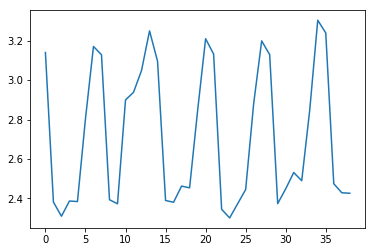

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.724656   
air_0164b9927d20bcc3_2017-04-23              1.330521   
air_0241aa3964b7f861_2017-04-23              2.361509   
air_0328696196e46f18_2017-04-23              2.162191   
air_034a3d5b40d5b1b1_2017-04-23              3.497841   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.610590  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.783013  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.606946  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.690158  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.044037

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l3_3000_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')